#Numerical Solutions for DEs HW3

YANG, Ze (5131209043)


## Problem 4: The non-linear pendulum.

In [1]:
%matplotlib inline
from __future__ import division
import time
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

f_s = lambda q: -np.sin(q)
g_s = lambda p: p
H_1 = lambda p,q: 0.5*p*p + np.cos(q)

def explicit_euler_solve(f, g, n, t0, t1, p0, q0):
    """
    explicit euler method, solve separable Hamiltonian system 
    p'(t)=-D_q H, q'(t)=D_p H, p(t_0)=p_0, q(t_0)=q_0 by
    
    p_{n+1} <- p_{n} + hf(p_n, q_n).
    q_{n+1} <- q_{n} + hg(p_n, q_n).
    @param f: a function of p and q, which is the - gradient of H wrt q,
        and the derivative of p.
    @param g: a function of p and q, which is the gradient of H wrt p,
        and the derivative of q.
    @param n: the number of steps.
    @param t0, p0, q0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t = np.linspace(t0, t1, n+1)
    p, q = np.zeros(n+1), np.zeros(n+1)
    p[0], q[0] = p0, q0
    for k in range(n):
        p[k+1] = p[k] + h*f(q[k])
        q[k+1] = q[k] + h*g(p[k])
    return t, p, q


def symplectic_euler_solve(f, g, n, t0, t1, p0, q0):
    """
    semi-implicit euler method, solve separable Hamiltonian system 
    p'(t)=-D_q H, q'(t)=D_p H, p(t_0)=p_0, q(t_0)=q_0, 
    in which H(p, q) = T(p) + V(q), by
    
    p_{n+1} <- p_{n} + hf(p_{q_n).
    q_{n+1} <- q_{n} + hg(p_{n+1}).
    @param f: a function of q, which is the - gradient of H wrt q,
        and the derivative of p.
    @param g: a function of p, which is the gradient of H wrt p,
        and the derivative of q.
    @param n: the number of steps.
    @param t0, p0, q0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t = np.linspace(t0, t1, n+1)
    p, q = np.zeros(n+1), np.zeros(n+1)
    p[0], q[0] = p0, q0
    for k in range(n):
        p[k+1] = p[k] + h*f(q[k])
        q[k+1] = q[k] + h*g(p[k+1])
    return t, p, q


def hamilton_error(H_func, result, H_exact):
    """
    calcuate the error in Hamilton function.
    @param H_func: the hamilton function H = H(p, q)
    @param result: the result of numerical calculation y = (p, q)
    @param H_exact: the exact value of H, which is a constant.
    """
    n = len(result[0])
    err = []
    for k in range(n):
        pk, qk = result[0][k], result[1][k]
        err.append(H_func(pk, qk) - H_exact)
    return err

In [2]:
if __name__ == '__main__':
    p0, q0 = 0, 1
    n, h = 300, 1/5
    t1, p1, q1 = explicit_euler_solve(f_s, g_s, n, 0, n*h, 0, 1)
    err_1 = hamilton_error(H_1, (p1, q1), H_1(p0, q0))
    
    t2, p2, q2 = symplectic_euler_solve(f_s, g_s, n, 0, n*h, 0, 1)
    err_2 = hamilton_error(H_1, (p2, q2), H_1(p0, q0))

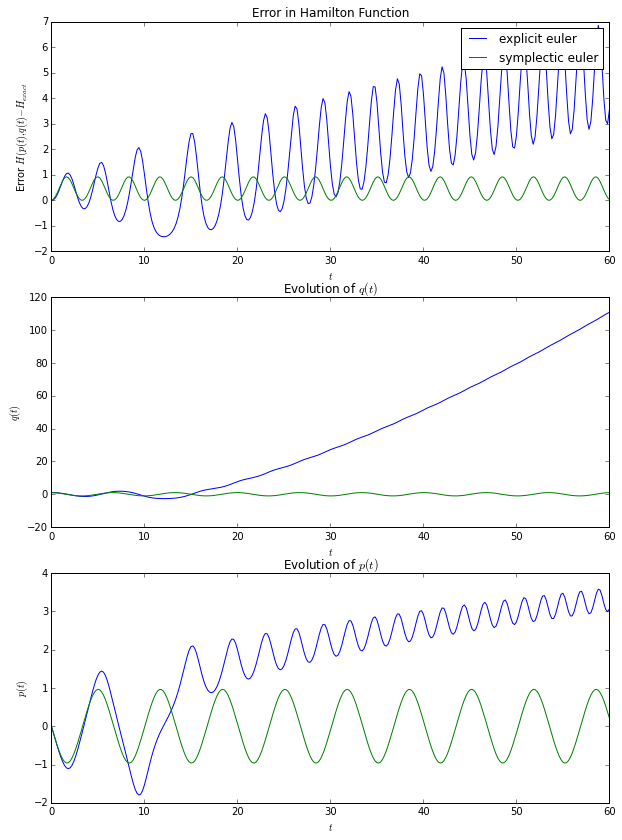

In [3]:
fig = plt.figure(figsize=(10,14))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(t1, err_1)
ax1.plot(t2, err_2)
ax1.set_title('Error in Hamilton Function')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Error $H(p(t), q(t)-H_{exact}$')
ax1.legend(['explicit euler', 'symplectic euler'])
              
ax2.plot(t1, q1)
ax2.plot(t2, q2)
ax2.set_title('Evolution of $q(t)$')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$q(t)$')

ax3.plot(t1, p1)
ax3.plot(t2, p2)
ax3.set_title('Evolution of $p(t)$')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$p(t)$')

## Problem 5: Implicit Methods
Implement implicit Euler, implicit midpoint and trapezoid method. Compare the rate of convergence and their execution time.

In [4]:
# test cases
test_cases = {
    1: lambda t,y: np.pi * np.cos(np.pi * t),
    2: lambda t,y: t + y,
    3: lambda t,y: np.exp(t),
    4: lambda t,y: -20*y + 20* t + 1,
    5: lambda t,y: (y**2) * (t - t**3),
    6: lambda t,y: t**2 - y
}

# initial conditions
t0, t1, y0 = 0.0, 3.0, 1.0

# the library we used in last hw.
def err_est(method, f, n_sample, t0, t1, y0):
    """
    estimate the error of an numerical solution relative
    to an exact solution, which is obtained by using a very small h.
    
    @param method: function, the numerical method being used.
    @param f: a function of t and y, which is the derivative of y.
    @param n_sample: # of different choices of h that are tested.
    """
    nks, errs, t_elapsed = [], [], []
    # calculate "exact" solution using a very small h
    n_large = 2**18
    t_ex, y_ex = method(f, n_large, t0, t1, y0)
    
    for k in range(n_sample):
        n_k = 2**(k+3)
        s_k = int(n_large/n_k)
        start_time = time.time()
        # do the numerical procudure with given choice of h,n
        t_path, path = method(f, n_k, t0, t1, y0)
        t_elapsed.append(time.time() - start_time)
        # calc errors 
        path_matched = [y_ex[s_k*i] for i in range(len(path))] 
        err = max(np.abs(path - path_matched))
        errs.append(err)
        nks.append(n_k)
    return nks, errs, t_elapsed

def implicit_euler_solve(f, n, t0, t1, y0):
    """
    implicit method, solve IVP y'(t)=f(t,y(t)), y(0)=y_0 by
    y_{n+1} <- y_{n} + hf(t_{n+1}, y_{n+1}).
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param t0, y0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t_path: the array {t_k}_1^n
    @return path: the array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    implicit = lambda y_next, k : (
        y_next - y[k] - h * f(t[k+1], y_next)
    )
    for k in range(n):
        y[k+1] = scipy.optimize.newton(
            func=implicit, x0=y[k], 
            fprime=None, args=(k,), maxiter=50)
    return t, y


def trapezoid_solve(f, n, t0, t1, y0):
    """
    trapezoid method, solve IVP y'(t)=f(t,y(t)), y(0)=y_0 by
    y_{n+1} <- y_{n} + h/2(f(t_n, y_{n}) + f(t_{n+1}, y_{n+1})).
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param t0, y0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t_path: the array {t_k}_1^n
    @return path: the array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    implicit = lambda y_next, k : (
        y_next - y[k] - (h/2) * (f(t[k], y[k]) + f(t[k+1], y_next))
    )
    for k in range(n):
        y[k+1] = scipy.optimize.newton(
            func=implicit, x0=y[k], 
            fprime=None, args=(k,), maxiter=50)
    return t, y


def implicit_midpoint(f, n, t0, t1, y0):
    """
    implicit midpoint method, solve IVP y'(t)=f(t,y(t)), y(0)=y_0 by
    y_{n+1} <- y_{n} + h f((t_n + t_{n+1})/2, (y_n + y_{n+1})/2).
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param t0, y0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t_path: the array {t_k}_1^n
    @return path: the array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    implicit = lambda y_next, k : (
        y_next - y[k] - h * f((t[k]+t[k+1])/2, (y[k]+y_next)/2)
    )
    for k in range(n):
        y[k+1] = scipy.optimize.newton(
            func=implicit, x0=y[k], 
            fprime=None, args=(k,), maxiter=50)
    return t, y


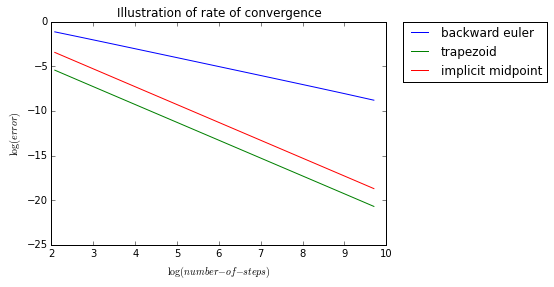

In [5]:
if __name__ == '__main__':
    nks ,errs, t_elapsed = err_est(implicit_euler_solve, test_cases[6], 12, t0, t1, y0)
    nks2 ,errs2, t_elapsed2 = err_est(trapezoid_solve, test_cases[6], 12, t0, t1, y0)
    nks3 ,errs3, t_elapsed3 = err_est(implicit_midpoint, test_cases[6], 12, t0, t1, y0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.log(nks) ,np.log(errs))
    ax.plot(np.log(nks2) ,np.log(errs2))
    ax.plot(np.log(nks3) ,np.log(errs3))

    ax.set_title('Illustration of rate of convergence')
    ax.set_xlabel('$\log(number-of-steps)$')
    ax.set_ylabel('$\log(error)$')
    ax.legend(['backward euler', 'trapezoid', 'implicit midpoint'],
              bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

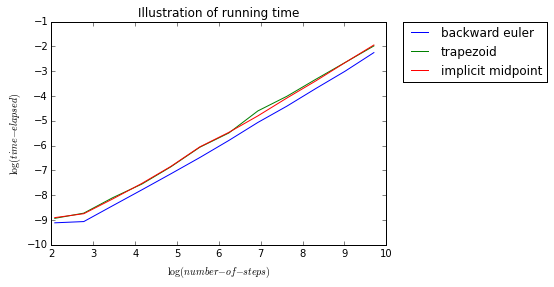

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)    
ax.plot(np.log(nks), np.log(t_elapsed))
ax.plot(np.log(nks2), np.log(t_elapsed2))
ax.plot(np.log(nks3), np.log(t_elapsed3))
ax.set_title('Illustration of running time')
ax.set_xlabel('$\log(number-of-steps)$')
ax.set_ylabel('$\log(time-elapsed)$')
ax.legend(['backward euler', 'trapezoid', 'implicit midpoint'],
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

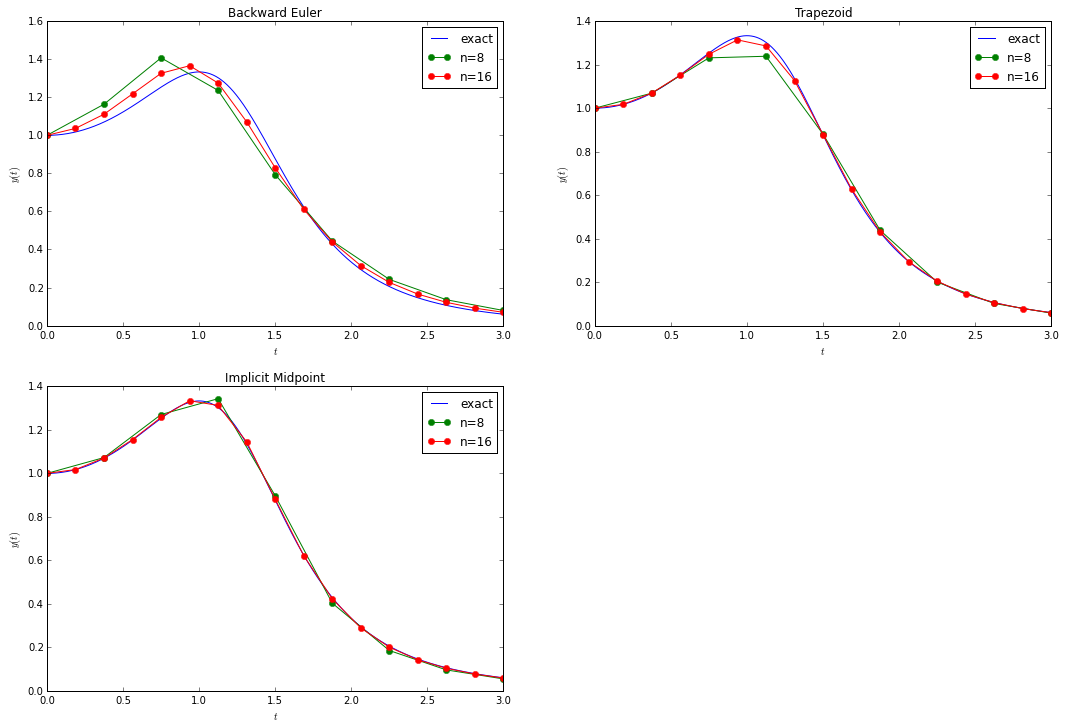

In [7]:
# initial conditions
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

t_ex, y_ex = implicit_euler_solve(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = implicit_euler_solve(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = implicit_euler_solve(test_cases[5], 16, 0.0, 3.0, 1.0)
ax1.plot(t_ex, y_ex)
ax1.plot(t1, y1, '.-', markersize=12)
ax1.plot(t2, y2, '.-', markersize=12)
ax1.set_title('Backward Euler')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$y(t)$')
ax1.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = trapezoid_solve(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = trapezoid_solve(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = trapezoid_solve(test_cases[5], 16, 0.0, 3.0, 1.0)
ax2.plot(t_ex, y_ex)
ax2.plot(t1, y1, '.-', markersize=12)
ax2.plot(t2, y2, '.-', markersize=12)
ax2.set_title('Trapezoid')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$y(t)$')
ax2.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = implicit_midpoint(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = implicit_midpoint(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = implicit_midpoint(test_cases[5], 16, 0.0, 3.0, 1.0)
ax3.plot(t_ex, y_ex)
ax3.plot(t1, y1, '.-', markersize=12)
ax3.plot(t2, y2, '.-', markersize=12)
ax3.set_title('Implicit Midpoint')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$y(t)$')
ax3.legend(['exact', 'n=8', 'n=16'])